In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchdiffeq

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = keras.datasets.mnist.load_data()
X_train,X_test = X_train[:,np.newaxis]/255,X_test[:,np.newaxis]/255

In [8]:
tensor = torch.tensor([1.,2.,3.])
tensor.normal_()

tensor([-0.1484,  1.3425, -0.8982])

In [3]:
class ODEFunc(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.conv1 = nn.Conv2d(dim,dim,3,padding=1)
        self.conv2 = nn.Conv2d(dim,dim,3,padding=1)
    
    def forward(self, t, x):
        x = x.
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        return x

In [4]:
class ODEBlock(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.func = ODEFunc(dim)
        self.itime = torch.Tensor([0,1])
    
    def forward(self, x):
        itime = self.itime.type_as(x)
        return torchdiffeq.odeint_adjoint(
            self.func, x, itime, rtol=1e-1, atol=1e-1)[1]

In [5]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.norm0 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,8,7,padding=0)
        self.norm1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8,16,7,padding=0)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,32,1,padding=0)
        self.norm3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32,64,1,padding=0)
        self.norm4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64,64,1,padding=0)
        self.norm5 = nn.BatchNorm2d(64)
        self.ode = ODEBlock(64)
        self.fc = nn.Linear(64,10)
    
    def forward(self, x):
        x = self.norm0(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv5(x)
        x = self.norm5(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.ode(x)
        x = x.view((-1,64))
        x = self.fc(x)
        x = F.softmax(x, dim=-1)
        return x

In [6]:
device = torch.device('cuda')
data,label = X_train,Y_train
data = torch.Tensor(data).to(device)
label = torch.Tensor(label).to(device).type(torch.long)
net = Net().to(device)
los = nn.CrossEntropyLoss().to(device)
opt = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [7]:
for _ in range(10):
    loss_avg = 0
    loss_cnt = 0
    for batch_idx in range(0,data.shape[0],128):
        batch = data[batch_idx:batch_idx+128]
        opt.zero_grad()
        output = net(batch)
        loss = los(output, label[batch_idx:batch_idx+128])
        loss.backward()
        opt.step()
        print(batch_idx)
        loss_avg += loss.item()
        loss_cnt += 1
    print(loss_avg/loss_cnt)

0
128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3072
3200
3328
3456
3584
3712
3840
3968
4096
4224
4352
4480
4608
4736
4864
4992
5120
5248
5376
5504
5632
5760
5888
6016
6144
6272
6400
6528
6656
6784
6912
7040
7168
7296
7424
7552
7680
7808
7936
8064
8192
8320
8448
8576
8704
8832
8960
9088
9216
9344
9472
9600
9728
9856
9984
10112
10240
10368
10496
10624
10752
10880
11008
11136
11264
11392
11520
11648
11776
11904
12032
12160
12288
12416
12544
12672
12800
12928
13056
13184
13312
13440
13568
13696
13824
13952
14080
14208
14336
14464
14592
14720
14848
14976
15104


KeyboardInterrupt: 

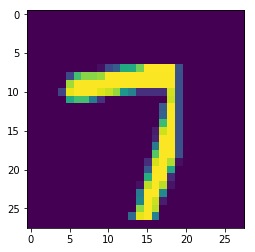

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64, 1, 1])

In [8]:
test = np.random.randint(0,X_train.shape[0])
plt.imshow(X_train[test,0])
plt.show()
np.argmax(net(data[test:test+1])[0].cpu().detach().numpy())